# Preprocessing the data

Step 1: Import necessary libraries

In [2]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from matplotlib import pyplot as plt

Step 2: Load the dataset

In [3]:
df = pd.read_csv("labeled_final_train.csv")
df.head()

,id,sentence1,sentence2,label
0,1,"In Paris , in October 1560 , he secretly met t...","In October 1560 , he secretly met with the Eng...",0
1,2,The NBA season of 1975 -- 76 was the 30th seas...,The 1975 -- 76 season of the National Basketba...,1
2,3,"There are also specific discussions , public p...","There are also public discussions , profile sp...",0
3,4,When comparable rates of flow can be maintaine...,The results are high when comparable flow rate...,1
4,5,It is the seat of Zerendi District in Akmola R...,It is the seat of the district of Zerendi in A...,1


Step 3: Tokenize the text data

Tokenization: Split each question into individual words or tokens using a tokenizer like NLTK or spaCy.

In [20]:
nltk.download('punkt')
nltk.download('wordnet')

def tokenize_text(text):
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t.isalpha()]  # remove punctuation
    return tokens

df['sentence1_tokens'] = df['sentence1'].apply(tokenize_text)
df['sentence2_tokens'] = df['sentence2'].apply(tokenize_text)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\astro\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\astro\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0        [In, October, secretly, met, English, ambassad...
1        [The, season, National, Basketball, Associatio...
2        [There, also, public, discussion, profile, spe...
3        [The, result, high, comparable, flow, rate, ma...
4            [It, seat, district, Zerendi, Akmola, region]
                               ...                        
49396    [Our, School, Temporal, Spiritual, Love, The, ...
49397              [She, Cork, June, arrived, Downs, July]
49398    [John, John, Cecil, child, George, Cornelia, S...
49399    [The, fourth, season, premiered, June, Like, t...
49400    [It, also, known, one, location, mainland, Cal...
Name: sentence2_tokens, Length: 49401, dtype: object


step 4 : Remove stopwords

Stopword removal: Remove common stopwords like "the", "and", "a", etc. that don't add much value to the meaning.

In [4]:
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def remove_stopwords(tokens):
    tokens = [t for t in tokens if t not in stop_words]
    return tokens

df['sentence1_tokens'] = df['sentence1_tokens'].apply(remove_stopwords)
df['sentence2_tokens'] = df['sentence2_tokens'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\astro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Step 5: Lemmatize the tokens

Stemming or Lemmatization: Reduce words to their base form (e.g., "running" becomes "run") using a stemmer or lemmatizer like PorterStemmer or WordNetLemmatizer.

In [5]:
lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(tokens):
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return tokens

df['sentence1_tokens'] = df['sentence1_tokens'].apply(lemmatize_tokens)
df['sentence2_tokens'] = df['sentence2_tokens'].apply(lemmatize_tokens)

Step 6: Convert tokens back to text

In [6]:
def tokens_to_text(tokens):
    text = ' '.join(tokens)
    return text

df['sentence1'] = df['sentence1_tokens'].apply(tokens_to_text)
df['sentence2'] = df['sentence2_tokens'].apply(tokens_to_text)

Step 7: Vectorize the text data using TF-IDF

Vectorization: Convert text data into numerical vectors using techniques like:
Bag-of-Words (BoW)
Term Frequency-Inverse Document Frequency (TF-IDF)
Word Embeddings (e.g., Word2Vec, GloVe)

In [7]:
vectorizer = TfidfVectorizer(max_features=5000)

X = vectorizer.fit_transform(df['sentence1'] + ' ' + df['sentence2'])
y = df['label']

In [8]:
X

<49401x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 417874 stored elements in Compressed Sparse Row format>

In [9]:
y

0        0
1        1
2        0
3        1
4        1
        ..
49396    0
49397    1
49398    0
49399    0
49400    0
Name: label, Length: 49401, dtype: int64

# Splitting the data

Split into training, validation, and testing sets: Divide the preprocessed data into three sets: training (e.g., 80%), validation (e.g., 10%), and testing (e.g., 10%) using train_test_split() from scikit-learn.

In [10]:
from sklearn.model_selection import train_test_split

# Define the test and validation size
test_size = 0.2
val_size = 0.25  # 0.25 x 0.8 = 0.2

# Split the data into training+validation set and testing set
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

# Split the training+validation set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size, random_state=42)


In [11]:
X_train = X_train.toarray()
X_val = X_val.toarray()
X_test = X_test.toarray()

In [12]:
print(X_train.shape, y_train.shape)

(29640, 5000) (29640,)


# Building the model

Build a Baseline Model

1. Choose a model architecture: Select a suitable model architecture for paraphrase detection. 
    Thus we use Recurrent Neural Network (RNN)
    
2. Implement the model: Implement the chosen model architecture using a deep learning library like TensorFlow, Keras, or PyTorch.

3. Train the model: Train the model on the training set, monitoring the validation set performance to avoid overfitting.

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, concatenate, Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Create a tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['sentence1'] + df['sentence2'])

# Convert text data to sequences
sequences1 = tokenizer.texts_to_sequences(df['sentence1'])
sequences2 = tokenizer.texts_to_sequences(df['sentence2'])

# Calculate the maximum length of the sequences
max_length = max(len(x) for x in sequences1 + sequences2)

# Pad the sequences
padded_sequences1 = pad_sequences(sequences1, maxlen=max_length)
padded_sequences2 = pad_sequences(sequences2, maxlen=max_length)

# One-hot encode the labels
y_onehot = pd.get_dummies(y).values

# Split the data
from sklearn.model_selection import train_test_split

X_train1, X_test1, X_train2, X_test2, y_train, y_test = train_test_split(
    padded_sequences1, padded_sequences2, y_onehot, test_size=0.2, random_state=42)

# Create the model
input1 = Input(shape=(max_length,))
input2 = Input(shape=(max_length,))

x1 = Embedding(input_dim=5000, output_dim=128)(input1)
x1 = LSTM(units=64, dropout=0.2, recurrent_dropout=0.2)(x1)

x2 = Embedding(input_dim=5000, output_dim=128)(input2)
x2 = LSTM(units=64, dropout=0.2, recurrent_dropout=0.2)(x2)

concat = concatenate([x1, x2])

output = Dense(2, activation='softmax')(concat)

model = Model(inputs=[input1, input2], outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit([X_train1, X_train2], y_train, 
          validation_data=([X_test1, X_test2], y_test), 
          epochs=5, batch_size=32)

Epoch 1/5
1235/1235 ━━━━━━━━━━━━━━━━━━━━ 36s 25ms/step - accuracy: 0.5626 - loss: 0.6860 - val_accuracy: 0.5897 - val_loss: 0.6666
Epoch 2/5
1235/1235 ━━━━━━━━━━━━━━━━━━━━ 28s 23ms/step - accuracy: 0.6054 - loss: 0.6553 - val_accuracy: 0.5982 - val_loss: 0.6598
Epoch 3/5
1235/1235 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.6245 - loss: 0.6339 - val_accuracy: 0.5898 - val_loss: 0.6758
Epoch 4/5
1235/1235 ━━━━━━━━━━━━━━━━━━━━ 28s 23ms/step - accuracy: 0.6409 - loss: 0.6169 - val_accuracy: 0.5713 - val_loss: 0.6988
Epoch 5/5
1235/1235 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.6555 - loss: 0.6019 - val_accuracy: 0.5550 - val_loss: 0.7309


# Evaluate and Refine the Model

+ Evaluate the model: Evaluate the model's performance on the testing set using metrics like accuracy, F1-score, precision, recall, and AUC-ROC.

#### Evaluation:-

1. Confusion Matrix: Let's take a look at the confusion matrix to see how the model is performing on each class.

    This will give us an idea of how many true positives, false positives, true negatives, and false negatives the model is producing.

In [14]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict([X_test1, X_test2])
y_pred_class = np.argmax(y_pred, axis=1)
y_test_class = np.argmax(y_test, axis=1)

conf_mat = confusion_matrix(y_test_class, y_pred_class)
print(conf_mat)

309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
[[4590  959]
 [3438  894]]


2. ROC-AUC Curve: Let's plot the ROC-AUC curve to see how well the model is separating the classes.
                This will give us an idea of how well the model is performing in terms of true positive rate and false positive rate.

309/309 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step


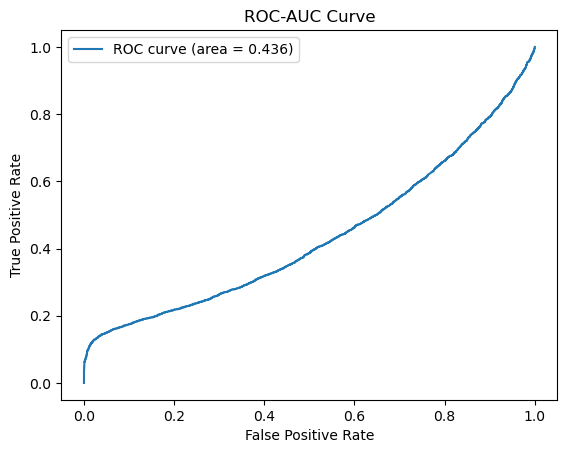

In [15]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

y_pred_proba = model.predict([X_test1, X_test2])[:, 1]
fpr, tpr, _ = roc_curve(y_test_class, y_pred_proba)
auc = roc_auc_score(y_test_class, y_pred_proba)

plt.plot(fpr, tpr, label='ROC curve (area = {:.3f})'.format(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend()
plt.show()

#### Improvement:-
1. Hyperparameter Tuning: Let's try tuning some hyperparameters to see if we can improve the model's performance. We can use a grid search or random search to find the optimal hyperparameters.

In [16]:
print(X_train.shape, y_train.shape)

(29640, 5000) (39520, 2)


In [17]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

IndexError: index 35702 is out of bounds for axis 0 with size 29640

In [18]:
from sklearn.utils import resample

X_resampled, y_resampled = resample(X_train, y_train, n_samples=31616, replace=True)

ValueError: Found input variables with inconsistent numbers of samples: [29640, 39520]